# Model Training and Evaluation

In [262]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate


import pickle
import os


## Base Models

The first set of implemented models will be based on the simplest preprocessing methods without any feature engineering. These models will act as a benchmark for all subsequent attempts. The set will include a K-Neighbors Classifier, Decision Tree, Gradient Boosting, Random Forest, Linear Discriminant Analysis, and Logistic Regression models. The models will be compared, and a feature importance plot will be plotted using the best-performing model. 

### Base Models with Iteratively Imputed Data

The models will first be implemented with the data imputed with the Iterative Imputer. The dataset is loaded below.

In [315]:
train_imputed_iterative = pd.read_pickle('../Data/Preprocessed/train_imputed_iterative.pkl')

In [316]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The models to be implemented are first defined inside a dictionary. A results list is instantiated to save the model score results. Since this is a classification problem, the metrics of interest will be *accuracy*, *precision* and *recall*. *Precision* can be viewed as the accuracy of the positive predictions, it can be calculated as follows:

$$precision = \frac{TP}{TP + FP},$$

where $TP$ is the number of true positives, and $FP$ is the number of false positives. This metric is usually reported alongside *recall*, also called *sensitivity* or the *true positive rate* (TPR). *Recall* is the ratio of positive instances that are correctly classified. *Recall* can be calculated as follows:

$$recall = \frac{TP}{TP + FN},$$

where $TP$ is the number of true positives and $FN$, the number of false negatives [(Aurelian Géron, 2023)](#ref-Geron2023).


K-Fold cross-validation (with 10 splits) is used to avoid overfitting. K=10 was chosen as it is a generally acceptable number for this method. The results from the cross-validation are stored in a pickle file for further use. 

In [340]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')


The results are now printed, and accuracy plots are presented for comparison purposes. 

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943275
                             Precision  0.951293
                             Recall     0.948455
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962860
                             Precision  0.955403
                             Recall     0.980194


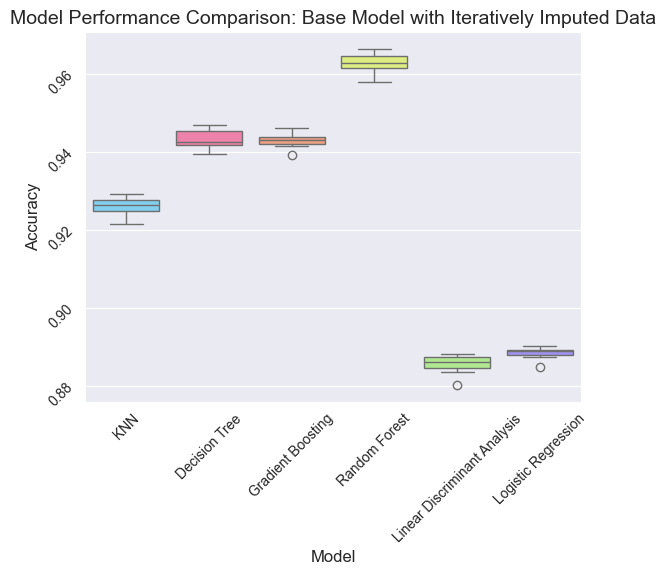

In [342]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Iteratively Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

The plot above and the comparison data frame for the results clearly show that the Random Forrest model outperformed the others. It has achieved an accuracy of 0.963, a precision of 0.955 and a recall of 0.98. These results are surprisingly high for a base model.

### Base Model with KNN Imputer 

The KNN-imputed data will now be imported for the next set of model comparisons. The same steps will be undertaken as in the previous implementation.

In [343]:
train_imputed_knn = pd.read_pickle('../Data/Preprocessed/train_imputed_knn.pkl')

In [344]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [345]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943101
                             Precision  0.951318
                             Recall     0.948095
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962966
                             Precision  0.955518
                             Recall     0.980256


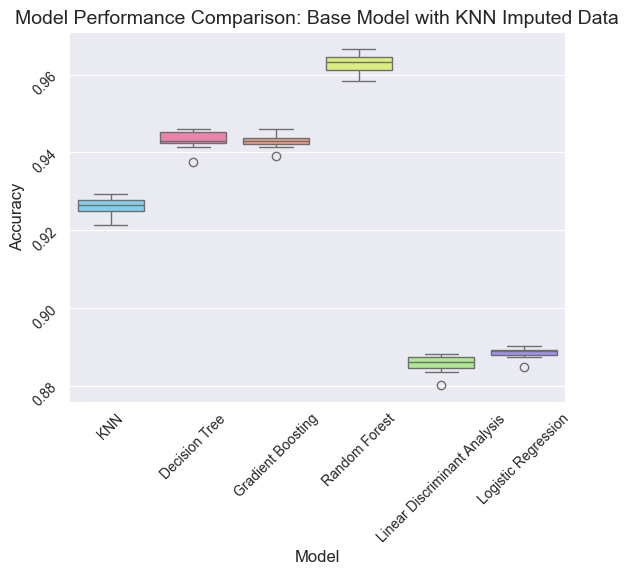

In [346]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with KNN Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Results with the KNN-imputed data look very similar to those obtained with the Itertive Imputer. The Random Forrest algorithm obtains an accuracy score of 0.963, a precision of 0.956, and a recall of 0.98. This is very close to the previous implementation. 

### Base Model with DropNa and Mode Imputation

Here, the data with the thrid imputation method will be imported. A reminder: entries with NaNs were dropped only for those features where the number of NaNs was less than the established threshold of 5% (of the data size). For all other features, the mode was used to impute the missing values. This imputation method assumes that the 'Non-Applicable' categories are irrelevant for response predictions.

In [347]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed_dropna_mode.pkl')

In [348]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [349]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943246
                             Precision  0.951545
                             Recall     0.948114
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.963062
                             Precision  0.955948
                             Recall     0.979950


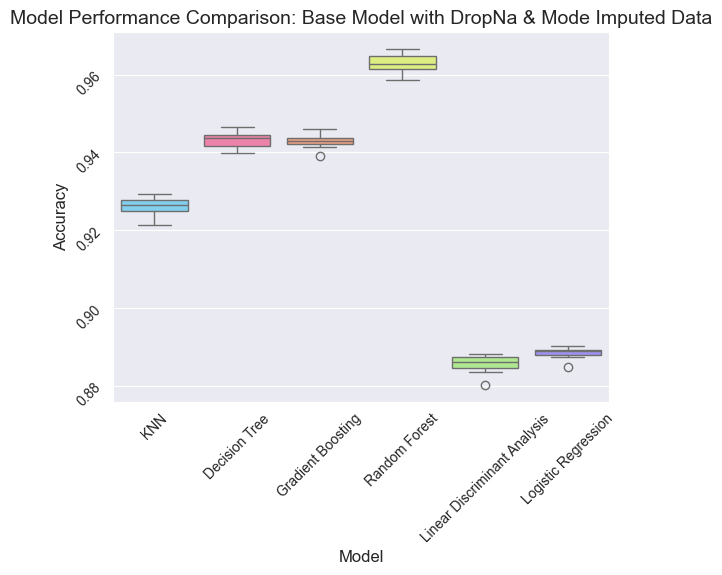

In [350]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Again, the plot looks similar to the previous two. The Random Forrest results are slightly better. This model reached an accuracy of 0.963, a precision of 0.956, and a recall of 0.98. This suggests that dropping the NaN entries has slightly helped the model performance. 

### Base Model with Non-Applicable Category

The last model comparison will be performed using the data set where the 'Non-Applicable' entries were given a separate category in the data. The missing values for the 'Arrival Delay in Minutes' feature were computed using the Iterative Imputer, with an `initial_strategy` set to the 'mean'. 

In [364]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [365]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [366]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943063
                             Precision  0.951120
                             Recall     0.948254
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.963187
                             Precision  0.956199
                             Recall     0.979901


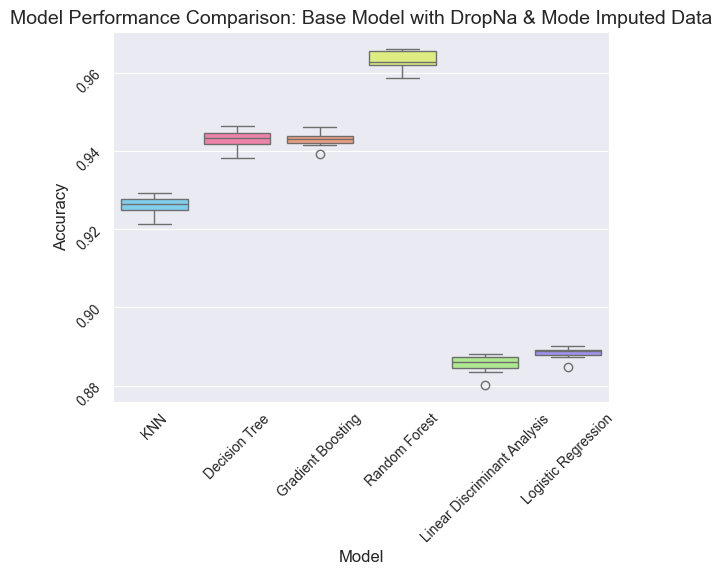

In [367]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The comparison plot looks similar to all the other attempts. The Random Forrest algorithm has achieved an accuracy of 0.963, a precision of 0.956 and a recall of 0.98. The results are slightly better than with the other data sets.

## Feature Engineering

Two attempts will be made with feature engineering, before proceeding to hyper-parameter tuning of the best performing model. The data for these models has been preprocessed in the `feature_engineering` notebook. 

### Feature Selection Model

In the first implementation, a dataset will be used that only includes a subset of the data. By eliminating features which do not have any impact on the response the model could potentially improve its predictive efficiency and accuracy. 

In [379]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [380]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [381]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fs/results_fs_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.942639
                             Precision  0.951172
                             Recall     0.947405
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.963091
                             Precision  0.955663
                             Recall     0.980326


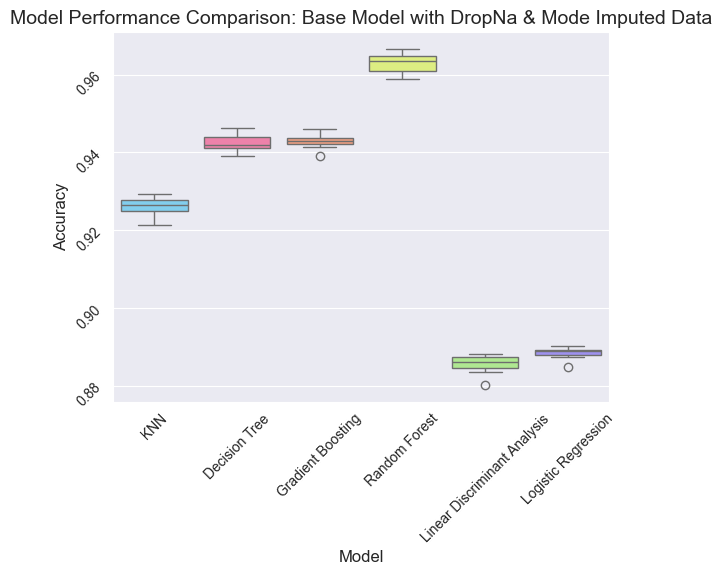

In [382]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fs/results_fs_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The plots and results do not show any large improvement in the predictive performance of the models from feature selection. The features dropped do not seem to have much impact on the model's predictive capacity. Neither do they bring anything when they are included.

### Feature Extraction Model

The same models will be tested with two extra aggregated features, `Overall Satisfaction Score` and `Premium Service`. The relevant dataset is imported.

In [383]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [384]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [385]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fe/results_fe_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943390
                             Precision  0.951485
                             Recall     0.948458
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962947
                             Precision  0.955850
                             Recall     0.979850


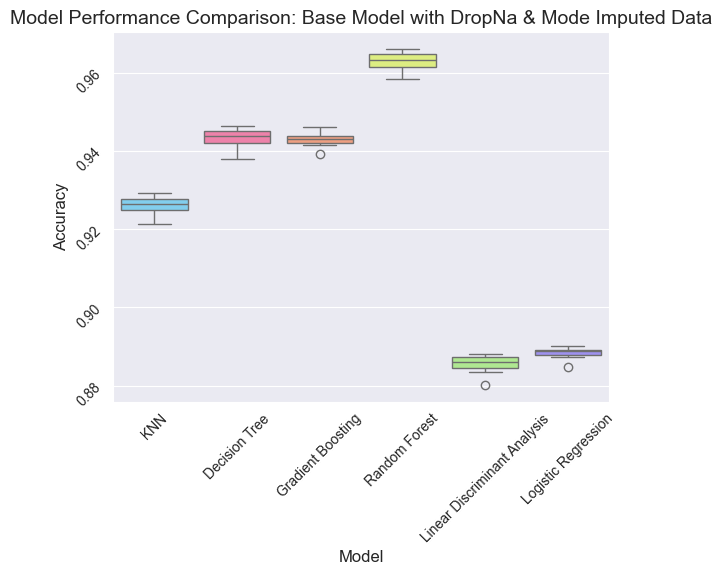

In [386]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fe/results_fe_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

Again, there is no change in the model's predictive performance. 

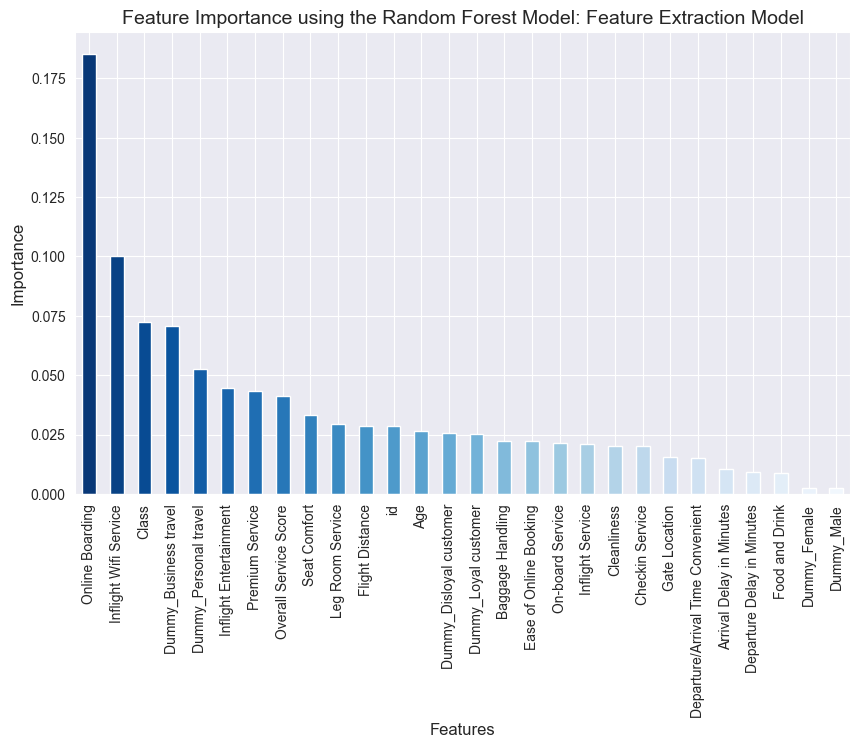

In [167]:
# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Model_3/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest Model: Feature Extraction Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

## References

1. <a id="ref-Geron2023"></a>Aurelian Géron, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd Edition), O'Reilly Media Inc, 20 January 2023.